# MSD

MDAnalysisのMSDを使うためには、座標をあらかじめunwrapしておく必要がある。しかし、trrファイルに対してどうやってunwrapしたらいいのかわからない。groファイルなら自力でunwrapできるが、今度はMDAlnalysisが連続フレームの読みこみに対応していない。しかたがないので、自作する。

trjconvに`-pbc nojump`オプションを付けて座標データを生成する。これによりunwrapされた原子位置(セル境界をまたいでも数値上飛びが生じない)になる。

In [57]:
import gromacs

with open("testcase/MethaneAR333-0.gro") as f:
    frames = [frame for frame in gromacs.read_gro(f)]


unwrapされているはずなので、単純に座標を引き算すると変位が得られる。

In [60]:
import numpy as np

dC = dict()
dH = dict()

# the last frame
for i, tail in enumerate(frames):
    atomname = np.array(tail["atom"])
    # the first frame
    for j in range(i):
        # displacements of all atoms
        # -pbc nojumpで生成した座標であれば、差をとるだけで良い。
        dr = tail["position"] - frames[j]["position"]

        # time difference in steps
        dt = i-j

        if dt > 100:
            continue
        
        # displacements of hydrogens
        H = dr[atomname == "H"]
        if dt not in dH:
            dH[dt] = []
        # store
        dH[dt].append(H)
        
        # displacements of carbons
        C = dr[atomname == "C"]
        if dt not in dC:
            dC[dt] = []
        # store
        dC[dt].append(C)
        
# mean square displacements of carbons
MSDC = [0]
# dt starts from 1
for dt in sorted(dC):
    # merge all data together
    d = np.vstack(dC[dt])
    # square displacement
    d = np.linalg.norm(d, axis=1)**2
    # mean 
    d = np.mean(d)
    MSDC.append(d)

MSDH = [0]
# dt starts from 1
for dt in sorted(dH):
    # merge all data together
    d = np.vstack(dH[dt])
    # square displacement
    d = np.linalg.norm(d, axis=1)**2
    # mean 
    d = np.mean(d)
    MSDH.append(d)
    

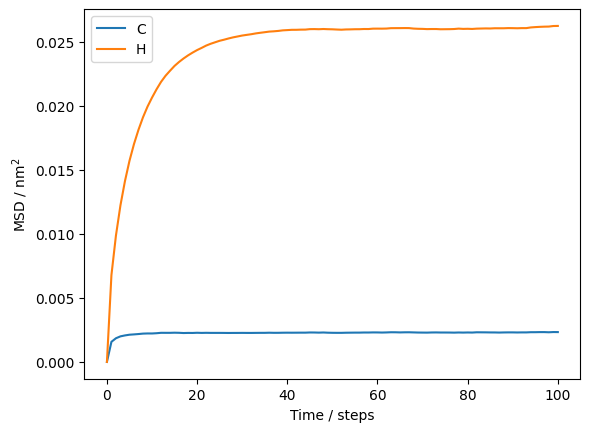

In [61]:
import matplotlib.pyplot as plt

plt.plot(MSDC, label="C")
plt.plot(MSDH, label="H")
plt.xlabel("Time / steps")
plt.ylabel(r"MSD / nm$^2$")
plt.legend()




このグラフの傾きが拡散係数。MethaneAだとほぼ0。